In [1]:
# Telling matplotlib to work in the program and not as an external window
%matplotlib inline                  
from nptdms import TdmsFile           # Handling TDMS files
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from numpy import *
import matplotlib.cm as cm
import time
from scipy.optimize import curve_fit
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns; import pandas as pd
import warnings
from scipy.optimize import OptimizeWarning
import os, sys
from copy import deepcopy            # To completely copy lists and not references
from pandas import DataFrame, Series  # for convenience
import cv2                           # OpenCV for video and image procedures
                                   # generating a folder or deleting files, etc.
import multiprocessing as mp         # This is for preventing large videos to take too much internal memory
import shutil                        # Deleting folders
plt.rcParams.update({'font.size': 14})
import matplotlib.cm as cm
import statistics as stats

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def calcvelocity(rrange,sigma,vdiff,A,vmin):
    sigmaterm = 2*sigma**2
    distances = np.linspace(0,rrange,100)
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, vdiff*np.exp(-2*I/A)+vmin

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

def solution(phi,t,vmax,D_0): return exp(-t*vmax**2/(4*D_0))/(4*np.pi) * (2+exp(t*vmax**2*sin(phi)**2/(4*D_0))*sqrt(np.pi/(D_0*t))*t*vmax*sin(phi) + exp(t*vmax**2*sin(phi)**2/(4*D_0))*sqrt(np.pi*t/D_0)*vmax*sin(phi)*scipy.special.erf(sqrt(t/D_0)*vmax*sin(phi)/2))

def linfunction(xpoints,minput,ninput): return minput * xpoints + ninput

def linMSD(xpoints,minput): return minput * xpoints

def linMSD2(xpoints,minput,ninput): return minput * xpoints + ninput

def msd_1d(x):
    result = np.zeros_like(x)
    for i in range(1,len(x)): result[i] = np.average((x[i:] - x[:-i])**2)
    return result

def chi2(ydata,Nparams,f, *params):
    res = ydata - f(*params)
    redchi2 = sum(res**2)/(len(ydata)-Nparams)
    return res, redchi2

def acfangle_1d(x):
    result = np.zeros_like(x)
    for i in range(1,len(x)): result[i] = np.average(np.cos((x[i:] - x[:-i])*np.pi/180))
    result[0] = 1
    return result

def expfun(x,lp): return np.exp(-x/lp)

def vectorlength(x): return np.sqrt(pow(x[0],2)+pow(x[1],2))

def msd_2d(x,y):
    result = np.zeros_like(x)
    for i in range(1,len(x)): result[i] = np.average(pow(x[i:] - x[:-i],2)+pow(y[i:] - y[:-i],2))
    return result

def calcdrifttheory(v,r,tau,delay,base):
    dv = np.gradient(v,base)
    return tau/2*(1-delay/tau)*v*dv+tau*v**2/r

def analyseTDMS(file):
    # Print properties and channels of TDMS file
    tdms_file = TdmsFile(file)
    print('Properties (Root):')
    for name, value in tdms_file.object().properties.items():
        print(2*' ' + "{0}: {1}".format(name, value))
    for group in tdms_file.groups():
        print('\'' + group + '\'')
        print(2*' ' + 'Properties (' + '\'' + group + '\'' ')')
        for name, value in tdms_file.object(group).properties.items():
            print('')
        for channel in tdms_file.group_channels(group):
            print(2*' ' + channel.channel)

In [2]:
start = 23
stop = 25

folder = "./Data example"
savefolder = "."
dt = 0.05
pxtomum=0.0533#0.0719e-6
maxpower = 1
num = stop - start

R = 2.19e-6/2
T = 273.15+22
kB = 1.38064852e-23
eta=2.414e-5*10**(247.8/(T-140))
D_0 = kB*T/(6*np.pi*eta*R)
D_0 = 3.85e-14
amplitude = 1
steps = 11
folder2 = '/Users/alex/Documents/Projects/Santiago speed'
power = np.loadtxt(r''+str(folder2)+'/power.txt')
speed = np.loadtxt(r''+str(folder2)+'/v_paralel_50ms.txt')

plotvelocity            = True #PLot Velocity histogram
propagationangle        = False#True #Plot distribution propagation angle
calcreorientationtime   = False#True #Calculate the reorientationtime
plotangleMSD            = False#True #Calculate the MSD for the angle - Drot
ACFs                    = False#True #Calculates the ACF - persistence length, persistence time
compareVoltandV         = True #Compares the voltage with velocity
plottrajectory          = True #Plot the trajectory
radialanalyse           = True #Calculate density, v-profile
                               #Compares velocity and counts of particles moving out and in
positioninthepast       = False#True #Plot Comparision with the past radial position
statisticreachingcenter = False#True #Calculates the probability of reaching the center and time needed
MSD2D                   = False#True #Creates a MSD for the x-y-data
movieofpastposition     = False#True #Creates a movie of the last particle positions
statisticboundaryhit    = False#True #Creates plot for the time needed until it hits the boundary

Properties (Root):
  Boundary: 300.0
  CycleTime: 0.0
  Delay: 9
  Offset: -10.0
  Sigmanoise: 12.977713690461004
  Sigmavelo: 50.0
  Tau_r: 1.0
  Threshold: 6000
  Vmax: 1.0
  Vmin: 0.2
  Xsize: 800
'Data'
  Properties ('Data')
  Angle
  Delays
  Iterationtime
  N
  NLaser
  Phase
  Programtime
  Velocity
  Xc
  Xh
  Yc
  Yh
--- 12.79 seconds ---
size of the video =  800
length of the movie =  4102
 
Trajectory length
[ 4101.]


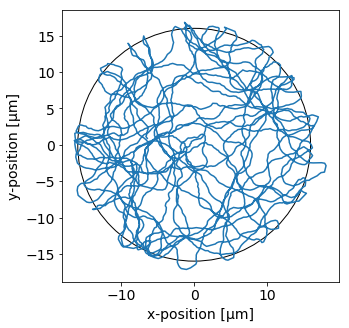

File:  23   19.32 seconds   - noise  12  - delay  9
Properties (Root):
  Boundary: 300.0
  CycleTime: 0.0
  Delay: 13
  Offset: -10.0
  Sigmanoise: 12.977713690461004
  Sigmavelo: 50.0
  Tau_r: 1.0
  Threshold: 6000
  Vmax: 1.0
  Vmin: 0.2
  Xsize: 800
'Data'
  Properties ('Data')
  Angle
  Delays
  Iterationtime
  N
  NLaser
  Phase
  Programtime
  Velocity
  Xc
  Xh
  Yc
  Yh
--- 9.7 seconds ---
size of the video =  800
length of the movie =  2969
Failed at j =  0  - i =  2926
 
Trajectory length
[ 2925.]


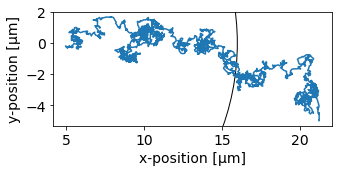

/Users/alex/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/alex/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/Users/alex/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/alex/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/Users/alex/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/alex/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeW

File:  24   15.39 seconds   - noise  12  - delay  13
Properties (Root):
  Boundary: 300.0
  CycleTime: 0.0
  Delay: 17
  Offset: -10.0
  Sigmanoise: 12.977713690461004
  Sigmavelo: 50.0
  Tau_r: 1.0
  Threshold: 6000
  Vmax: 1.0
  Vmin: 0.2
  Xsize: 800
'Data'
  Properties ('Data')
  Angle
  Delays
  Iterationtime
  N
  NLaser
  Phase
  Programtime
  Velocity
  Xc
  Xh
  Yc
  Yh
--- 12.84 seconds ---
size of the video =  800
length of the movie =  4102
 
Trajectory length
[ 4101.]


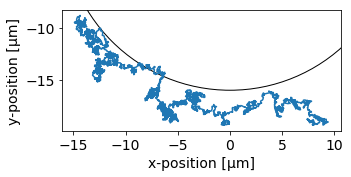

/Users/alex/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/alex/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/Users/alex/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/alex/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/Users/alex/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/alex/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeW

File:  25   24.82 seconds   - noise  12  - delay  17
Total time =  59.53


In [8]:
totaltime = 0
reorientationtime = meandensity = reorientationtime2 = Drot = Droterr = Drotexp = Drotexperr = np.nan
ptime = ptimeerr = plength = plengtherr = maxvelocity = meanvelocity = centermorein = centermoreout = np.nan
meantime = meanprob = notone = zerocount = meanvelocity = np.nan
for m in range(start,stop+1):
#for m in range(start,start+1):
    start_time = time.time() 
    number = m
    printnum=str(number)   
    if number < 10:
            tdms_file = TdmsFile(folder+"/Test_00"+str(number)+"_module.tdms")
            #analyseTDMS(folder+"/Test_00"+str(number)+"_module.tdms")
    else:
        if number < 100:
            tdms_file = TdmsFile(folder+"/Test_0"+str(number)+"_module.tdms")
            #analyseTDMS(folder+"/Test_0"+str(number)+"_module.tdms")
        else:
            tdms_file = TdmsFile(folder+"/Test_"+str(number)+"_module.tdms")
            #analyseTDMS(folder+"/Test_"+str(number)+"_module.tdms")
    print("--- %s seconds ---" % round((time.time() - start_time),2))

    Xc = tdms_file.channel_data('Data','Xc')
    Yc = tdms_file.channel_data('Data','Yc')
    velocitytheo = tdms_file.channel_data('Data','Velocity')
    angletheo = tdms_file.channel_data('Data','Angle')
    xolaser = tdms_file.channel_data('Data','Xh')
    yolaser = tdms_file.channel_data('Data','Yh')
    Nfound = tdms_file.channel_data('Data','N')
    Nlaser = tdms_file.channel_data('Data','NLaser')
    delaywave = tdms_file.channel_data('Data','Delays')
    iterationtime = tdms_file.channel_data('Data','Iterationtime')
    programtime = tdms_file.channel_data('Data','Programtime')
    phase = tdms_file.channel_data('Data','Phase')
    p = tdms_file.object().properties
    delay = int(p['Delay'])
    noise = int(p['Sigmanoise'])
    boundaryradius = p['Boundary']
    offset = p['Offset']
    sigmavelo = p['Sigmavelo']
    vmin = p['Vmin']
    vmax = p['Vmax']
    vfactor = vmax - vmin
    firstlength = len(Nfound)
    maxlength = 0
    for i in range(firstlength):
        if phase[i] == 0: maxlength += 1
    stepsexp = maxlength
    videosize = p['Xsize']
    timewave=np.linspace(0,maxlength*dt,maxlength)
    dtprogram = 13.6e-3                             #time of the program (tracking + calculation) [s]
    dtsendtoadwin = 1e-3                            #time to send signal from PC to Adwin [s]
    dttransferfromcamtocom = 1e-3                   #time to send from cam to PC (unknown) [s]
    dtframetransfer = videosize * 1.9176e-6         #time for frametransfer [s]
    dtreadout = (1032/(27e6) + 1.9176e-6)*videosize #time to readout the cam [s]
    savefolderplus = 'Noise '+str(noise)
    plotnum = str(noise) + ' - ' + str(delay)

    print('size of the video = ',videosize)
    print('length of the movie = ',maxlength)
    number = int(stats.mode(Nfound))
    maxnumber = int(max(Nfound))

    particles = np.zeros((maxlength,number,6))
    lastone = np.zeros((number,2))
    pre = np.zeros((maxlength,maxnumber,6))
    count = 0
    for i in range(maxlength):
        for j in range(int(Nfound[i])):
            pre[i,j,0] = Xc[count]
            pre[i,j,1] = Yc[count]
            pre[i,j,2] = velocitytheo[count]
            pre[i,j,3] = angletheo[count]
            count += 1
    count = 0
    for i in range(maxlength):
        for j in range(int(Nlaser[i])):  
            pre[i,j,4] = xolaser[count]
            pre[i,j,5] = yolaser[count]

    particles[0,:,:] = pre[0,:number,:]
    for i in range(1,maxlength):
        for j in range(number):
            if particles[i-1,j,0] != 0:
                lastone[j,0] = i-1
                lastone[j,1] = 0
            else: lastone[j,1] += 1
            xpre = particles[int(lastone[j,0]),j,0]
            ypre = particles[int(lastone[j,0]),j,1]
            mindist = 50; minnum = 666
            for k in range(int(Nfound[i])):     #Sort the trajectories be comparing the distance between the positions
                dist = np.sqrt(pow(xpre-pre[i,k,0],2)+pow(ypre-pre[i,k,1],2))
                if dist < mindist:
                    mindist = dist
                    minnum = k
                    #print('i = ',i,' - j = ',j,' - mindist = ',round(mindist,1),' - minnum = ',minnum)
            if minnum != 666: particles[i,j,:] = pre[i,minnum,:]

    for i in range(1,maxlength):
        for j in range(number):
            if particles[i,j,0] == 0:
                particles[i,j,0] = np.nan
                particles[i,j,1] = np.nan     
    particles[:,:,0:2] = (particles[:,:,0:2]-videosize/2)*pxtomum
    particles[:,:,4:7] = (particles[:,:,4:6]-videosize/2)*pxtomum
    save = particles

    #print('Fill gaps at:')
    trajlength = np.zeros(number)
    for j in range(number):
        lastfound = 0; out = True
        for i in range(1,maxlength):
            if out == True:
                if particles[i,j,0] != particles[i,j,0]:
                    lastfound = int(i-1)
                    count = 1; check = True
                    while check == True:
                        if particles[lastfound+count,j,0] == particles[lastfound+count,j,0]:
                            #print('j = ',j,' - i = ',i,' - gap = ',count)
                            check = False
                        else: count +=1
                        if count == 20:
                            print('Failed at j = ',j,' - i = ',i)
                            check = False
                            trajlength[j] = lastfound
                            particles[lastfound:,j,0] = np.nan
                            particles[lastfound:,j,1] = np.nan
                            out = False
                    #print('particle number = ',j,' - position = ',i,' gap length = ',count)
                    if out == True:
                        #for k in range(0,count+1):
                        #    print('...... i = ',lastfound+k,' - x = ',round(particles[lastfound+k,j,0],1))
                        for k in range(1,count+1):
                            particles[lastfound+k,j,0] = particles[lastfound,j,0]+(k/(count+1))*(particles[lastfound+count,j,0]-particles[lastfound,j,0])
                            particles[lastfound+k,j,1] = particles[lastfound,j,1]+(k/(count+1))*(particles[lastfound+count,j,1]-particles[lastfound,j,1])
                            particles[lastfound+k,j,2] = particles[lastfound,j,2]+(k/(count+1))*(particles[lastfound+count,j,2]-particles[lastfound,j,2])
                            particles[lastfound+k,j,3] = particles[lastfound,j,3]+(k/(count+1))*(particles[lastfound+count,j,3]-particles[lastfound,j,3])
                        #print('AFTER')
                        #for k in range(0,count+1):
                        #    print('...... i = ',lastfound+k,' - x = ',round(particles[lastfound+k,j,0],1))
                        #print('----------')
                if i == maxlength-1: 
                    trajlength[j] = i
    print(' ')
    print('Trajectory length')                  
    print(trajlength)


    fig=plt.figure(1, figsize = (5,5) )
    ax = plt.subplot(1,1,1)
    ax.set_aspect('equal')
    for i in range(number):
        ax.plot(particles[:,i,0],particles[:,i,1])
    circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='k', fill=False)
    ax.add_artist(circle2)
    plt.xlabel('x-position [µm]')
    plt.ylabel('y-position [µm]')
    plt.show()

    string_temp = savefolderplus + '/PlotSorting/'
    if not os.path.exists(string_temp): os.makedirs(string_temp)
    fig=plt.figure(1, figsize = (12,4) )
    plt.title('Laser vs particle position')
    plt.xlabel('Time [s]')
    plt.ylabel('x position')
    plt.scatter(timewave,particles[:,0,4],label='laser 1', s=2)
    plt.plot(timewave,particles[:,0,0],label='particle 1',color='r')
    plt.legend()
    plt.savefig(string_temp + 'Testsorting'+str(plotnum)+'.pdf', format='pdf')
    plt.close(fig)#plt.show()

    textwave = ['xy','Laserxy','Angle','General','Iterationtime','Programtime']
    for i in range(6):
        string_temp = savefolderplus + '/Data'+str(textwave[i])+'/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        if i == 0: np.savetxt(string_temp + 'Dataxy'+str(printnum)+'.txt', np.transpose([particles[:,0,0],particles[:,0,1]]),fmt='%1.6f')
        if i == 1: np.savetxt(string_temp + 'DataLaserxy'+str(printnum)+'.txt', np.transpose([particles[:,0,4],particles[:,0,5]]),fmt='%1.6f')
        if i == 2: np.savetxt(string_temp + 'DataAngle'+str(printnum)+'.txt', np.transpose([particles[:,0,3]]),fmt='%1.6f')
        if i == 3: np.savetxt(string_temp + 'DataGeneral'+str(printnum)+'.txt', np.transpose([dt,pxtomum,offset,videosize,boundaryradius,maxpower,sigmavelo,vmin,vmax,amplitude]),fmt='%1.6f')
#---------------------------------------------------              
    particlesdisplay = np.zeros((maxlength,1,5))
    particlesdisplay[:,0,0] = particles[:,0,0];particlesdisplay[:,0,1] = particles[:,0,1]
    #particlesdisplay=(particlesdisplay-videosize/2)*pxtomum
    directionvector = np.zeros((maxlength,2))
    movingvector = np.zeros((maxlength,2))
    velocity = np.zeros(maxlength);stepsize = np.zeros(maxlength)
    velocitywithdiffusion=np.zeros(maxlength)
    directionvector[:maxlength,0] = np.cos(particles[:maxlength,0,3]*np.pi/180)
    directionvector[:maxlength,1] = np.sin(particles[:maxlength,0,3]*np.pi/180)
    for i in range(2,maxlength):                           #Calc projection of the velocity in the required direction
        movingvector[i,0] = particlesdisplay[i,0,0]-particlesdisplay[i-1,0,0]
        movingvector[i,1] = particlesdisplay[i,0,1]-particlesdisplay[i-1,0,1]
        stepsize[i] = abs(np.dot(directionvector[i-2,:], movingvector[i,:]))
        velocity[i] = abs(np.dot(directionvector[i-2,:], movingvector[i,:]))/dt
    velocitywithdiffusion[:maxlength] = np.sqrt(pow(movingvector[:maxlength,0],2)+pow(movingvector[:maxlength,1],2))/dt 
    distancetocenter=[]                                    #Calc velocity 
    distancetocenter=np.sqrt(pow(particles[:,0,0]-videosize/2,2)+pow(particles[:,0,1]-videosize/2,2))
    binwave=np.linspace(min(velocity),min(max(velocitywithdiffusion),10),20)
    countin = 0
    for i in range(maxlength):
        if distancetocenter[i] < sigmavelo*pxtomum: countin += 1
    countin /= maxlength
    meanvelocity = np.mean(velocity)
    smoothvalue = 20
    smoothit = smooth(velocity,smoothvalue)
    
    #savefolder ='.'
    driftdelay = 1
    distancetocenter2=[]                                    #Calc velocity 
    distancetocenter2=np.sqrt(pow(particlesdisplay[:,0,0],2)+pow(particlesdisplay[:,0,1],2))
    directionvector = np.zeros((maxlength,2))
    movingvector = np.zeros((maxlength,2))
    #stepsize = np.zeros(maxlength)
        
    value = particles[:,0,2]
    steps2 = 6
    speedhisto= np.zeros((steps2,4))    #0 - angle, 1 - velocity, 2 - counts, 3 - variance
    speedcollect=np.zeros((steps2,maxlength))
    for i in range(steps2): speedhisto[i,0] = min(value)+(i+1)/steps2*(1-min(value))
    for i in range(maxlength):                      #Statistics over the velocity in required direction vs the theoretical velocity
        if value[i] < speedhisto[0,0]:
            speedhisto[0,1] += velocity[i]
            speedcollect[0,int(speedhisto[0,2])] = velocity[i]
            speedhisto[0,2] += 1
        else:
            for j in range(1,steps2):
                if value[i] > speedhisto[j-1,0] and value[i] < speedhisto[j,0]:
                    speedhisto[j,1] += velocity[i]
                    speedcollect[j,int(speedhisto[j,2])] = velocity[i]
                    speedhisto[j,2] += 1
    speedhisto[:,1] /= speedhisto[:,2]
    maxvelocitymeasured = speedhisto[-1,1]
    
    startpoint = []; endpoint =[]
    if distancetocenter[0] < boundaryradius*pxtomum:
        startpoint.append(0)
        check = 0
    else: check = 1; remi = -1   
    count = 0
    for i in range(1,maxlength):
        if distancetocenter[i] > boundaryradius*pxtomum:
            if check == 0:
                remi = i
                check = 1
            count += 1
        if check == 1: 
            if distancetocenter[i] < boundaryradius*pxtomum:
                check = 0
                if remi != -1:
                    startpoint.append(i)
                    endpoint.append(remi)
                else: startpoint.append(i)
            else: count += 1   
    if check == 1: endpoint.append(remi)
    else: endpoint.append(maxlength-1)
    
    newangle = np.zeros(maxlength); newangle = particles[:,0,3].copy()    #MSD for the theoretic moving direction
    diff = np.zeros(3)
    for i in range(1,maxlength):
        diff[0] = abs(newangle[i]-newangle[i-1])
        diff[1] = abs(newangle[i]-newangle[i-1]+360)
        diff[2] = abs(newangle[i]-newangle[i-1]-360)
        mini = min(diff)
        if mini != diff[0]:
            if mini == diff[1]: newangle[i:] += 360
            else: newangle[i:] -= 360
    for i in range(len(endpoint)-1): newangle[endpoint[i]:] -= newangle[endpoint[i]]-newangle[endpoint[i]-1]

    if noise != 0:
        check = True; i = 1
        reorwave= np.zeros((maxlength,2))
        while check == True:
            diff = np.zeros(maxlength-i)
            for j in range(i,maxlength): diff[j-i] = abs(newangle[j] - newangle[j-i])  #Calculate the direction change for i steps
            mean = np.mean(diff[:maxlength-i])   #Calculate the standard derivation
            reorwave[i,0] = i*dt
            reorwave[i,1] = mean
            if mean/57.3 >= 1: 
                check = False
                reorlen = i
            else: i += 1 
            if i == maxlength:
                reorlen = i
                i = 666/dt
                check = False       
        reorientationtime = i*dt 
    else: reorientationtime = 666

    radialdata = np.zeros((steps,15))  #0 - bins, 1 - counts, 2 - v, 3 - verr, 4 - v outwards, 5 - v outwards err
    base=boundaryradius*pxtomum/(steps-1)      # 6 - v inwards, 7 - v inwards err, 8 - density, 9 - v difference, 10 - v diff err, 11 - drift, 12 - drift err
    for i in range(steps): radialdata[i,0] = i*base
    averagebinposition = np.zeros(steps-1)
    for i in range(1,steps): averagebinposition[i-1] = (radialdata[i,0]+radialdata[i-1,0])/2

    step = np.zeros(maxlength); shell = np.zeros(maxlength); inout = [];radialdrift = 0
    collectdrift = np.zeros((maxlength,steps))
    collectvelocity = np.zeros((maxlength,steps,3))
    count = np.zeros((steps,3))
    for i in range(1,maxlength):
        j = 0
        check = False
        while check == False:
            if distancetocenter2[i] < radialdata[j,0] and distancetocenter2[i] > radialdata[j-1,0]:
                check = True
                radialdata[j,1] += 1
                collectvelocity[int(count[j,0]),j,0] = velocity[i]
                count[j,0] += 1                        
                radialdrift = distancetocenter2[i]-distancetocenter2[i-driftdelay]
                collectdrift[int(count[j,0]),j] = radialdrift
                step[i] = i; shell[i] = round(averagebinposition[j-1],2)
                if radialdrift > 0:  #moving outwards
                    collectvelocity[int(count[j,1]),j,1] = velocity[i]
                    count[j,1] += 1
                    inout.append('outwards')
                if radialdrift < 0:  #moving inwards
                    collectvelocity[int(count[j,2]),j,2] = velocity[i]
                    count[j,2] += 1
                    inout.append('inwards')
            else: j += 1
            if j == steps: check = True
        if shell[i] == 0:
            step[i] = i; shell[i] = 888
            if radialdrift < 0: inout.append('inwards')
            else: inout.append('outwards')

    for i in range(1,steps): 
        radialdata[i,2] = np.mean(collectvelocity[:int(count[i,0]),i,0])    #total velocity
        radialdata[i,3] = np.nanvar(collectvelocity[:int(count[i,0]),i,0])
        radialdata[i,4] = np.mean(collectvelocity[:int(count[i,1]),i,1])    #moving outwards
        radialdata[i,5] = np.nanvar(collectvelocity[:int(count[i,1]),i,1])
        radialdata[i,6] = np.mean(collectvelocity[:int(count[i,2]),i,2])    #moving inwards
        radialdata[i,7] = np.nanvar(collectvelocity[:int(count[i,2]),i,2])
        radialdata[i,8] = radialdata[i,1]/averagebinposition[i-1]                   #density
        radialdata[i,11] = -np.mean(collectdrift[:int(count[i,0]),i])/dt
        radialdata[i,12] = np.nanvar(collectdrift[:int(count[i,0]),i])/dt
    dr = radialdata[1,0]
    sumdensity = sum(radialdata[1:,8]*dr)
    radialdata[1:,8] /= sumdensity                                                  
    radialdata[1:,9] = radialdata[1:,6] - radialdata[1:,4]                  #velocity difference
    radialdata[1:,10] = np.sqrt(radialdata[1:,7]**2 + radialdata[1:,5]**2)
    meandensity = sum(averagebinposition*radialdata[1:,8])
    radialdata[1:,13] = count[1:,2]*radialdata[1:,6] - count[1:,1]*radialdata[1:,4]
    radialdata[1:,14] = count[1:,2]/(count[1:,1]+count[1:,2])*100

    dd, v = calcvelocity(boundaryradius*pxtomum,sigmavelo*pxtomum,vfactor,amplitude,vmin)
    diffv = np.gradient(v)/(dd[1]-dd[0])
    maxpos = np.argmax(diffv)
    maxdist = dd[maxpos]
    sigmawave = np.zeros(steps)
    base=boundaryradius*pxtomum/maxdist/(steps-1)      # 6 - v inwards, 7 - v inwards err, 8 - density, 9 - v difference, 10 - v diff err, 11 - drift, 12 - drift err
    for i in range(steps): sigmawave[i] = i*base
    averagesigmaposition = np.zeros(steps-1)
    for i in range(1,steps): averagesigmaposition[i-1] = (sigmawave[i]+sigmawave[i-1])/2
    ddnew = np.linspace(0,boundaryradius*pxtomum/maxdist,100)

    dr = dd[1]*1e6   
    string_temp = savefolderplus + '/PlotRadial/'
    if not os.path.exists(string_temp):
        os.makedirs(string_temp) 
    fig=plt.figure(1, figsize = (15,15) )
    ax1 = plt.subplot(3,2,1)
    color = 'tab:red'
    ax1.set_xlabel(r'r/$\sigma$')
    ax1.set_ylabel('Density [a.u.]', color=color)
    bars = ax1.bar(averagesigmaposition, radialdata[1:,8],base, color=color,alpha = 0.5, edgecolor = color,label='Simulation')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim([0,1.1*max(radialdata[1:,8])])
    ax1.set_xlim([0,boundaryradius*pxtomum/maxdist])
    ax1.axvline(x=meandensity,linewidth=0.5, color = 'k',linestyle='--',label = 'mean value')
    ax1.set_title(' ')
    theory = 1/(v**(1+delay*dt/reorientationtime))
    theory /= np.nansum(theory*dr)             
    line1 = ax1.plot(ddnew,theory, color='red', linewidth = 3,label = 'Volpe theory')

    schnitzer = 1/radialdata[1:,2]
    for i in range(len(schnitzer)):
        if radialdata[1+i,2] == 0: schnitzer[i] = np.nan
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('1/velocity [s/µm]', color=color)  # we already handled the x-label with ax1
    line2 = ax2.plot(averagesigmaposition,schnitzer, color=color, linewidth = 3,label='Schnitzer theory')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([0,1.1*np.nanmax(schnitzer)])
    lns = line1+line2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns,labs)

    ax3 = plt.subplot(3,2,2)
    diffv = np.gradient(v)/(dd[1]-dd[0])
    ax3.set_ylabel('$v_{in}-v_{out}$ [µm/s]')
    ax3.set_xlabel(r'r/$\sigma$')
    ax3.set_title(' ')
    ax3.scatter(averagesigmaposition,radialdata[1:,9],label ='$v_{in} - v_{out}$')
    ax3.plot(ddnew,diffv*np.nanmax(abs(radialdata[1:,9]))/max(diffv),color='r',label = 'dv/dt')
    ax3.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
    ax3.set_xlim([0,boundaryradius*pxtomum/maxdist])
    ax3.legend()

    ax4 = plt.subplot(3,2,3)
    ax4.errorbar(averagesigmaposition, radialdata[1:,2],yerr=radialdata[1:,3], fmt='o',label='Simulation')
    ax4.plot(ddnew,v*maxvelocitymeasured,label='Theory')
    ax4.set_xlabel(r'r/$\sigma$')
    ax4.set_ylabel('Velocity [µm/s]')
    ax4.set_xlim([0,boundaryradius*pxtomum/maxdist])
    ax4.legend()

    ax5 = plt.subplot(3,2,4)
    plt.scatter(averagesigmaposition,radialdata[1:,11],label='Simulation')
    ax5.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
    drifttheory = calcdrifttheory(v,dd,reorientationtime,delay*dt,dr)
    plt.plot(ddnew,drifttheory/drifttheory[2]*radialdata[1,11],'k--',label='Theory [a.u.]')
    ax5.set_xlabel(r'r/$\sigma$')
    ax5.set_ylabel('Drift [µm/s]')
    ax5.legend()

    percentage2 = count[:,2]/(count[:,1]+count[:,2])*100
    ax6 = plt.subplot(3,2,5)
    plt.plot(averagesigmaposition,radialdata[1:,14])
    plt.xlabel(r'r/$\sigma$')
    plt.ylabel('Percentage pointing inwards [%]')
    plt.axvline(x=boundaryradius/maxdist,linewidth=0.5, color = 'k',linestyle='--')
    plt.axhline(y=50,linewidth=0.5, color = 'k',linestyle='--')
    plt.ylim([0.98*np.nanmin(radialdata[1:,14]),1.02*np.nanmax(radialdata[1:,14])])
    plt.xlim([0,boundaryradius*pxtomum/maxdist])

    ax7 = plt.subplot(3,2,6)
    plt.plot(averagesigmaposition,radialdata[1:,13])
    plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
    plt.xlabel(r'r/$\sigma$')
    plt.ylabel(r'$N_{in} \cdot v_{in} - N_{out} \cdot v_{out}$ [a.u.]')
    plt.xlim([0,boundaryradius*pxtomum/maxdist])
    plt.axvline(x=boundaryradius*pxtomum/maxdist,linewidth=0.5, color = 'k',linestyle='--')

    plt.suptitle('delay = '+str(round(delay*dt/reorientationtime,2))+r'$\cdot \tau_{r}$  -  $\tau_{r} = $'+str(round(reorientationtime,1))+' s')
    plt.tight_layout() 
    plt.savefig(string_temp+'Density layout'+str(int(noise))+' - '+str(int(delay))+'.pdf', format='pdf')
    plt.close(fig)#plt.show()  
    
    #savefolder = '.'
    string_temp = savefolderplus + '/DataRadial2/'
    if not os.path.exists(string_temp): os.makedirs(string_temp)           #0 - xpos             1 - mean v       2 - std v        3 - mean v_out   4 - std v_out    5 - mean v_in    6 - std v_in     7 - density      8 - v diff       9 - v diff std    10 - Drift        11 - std Drift    12 - % inwards  13 - N*v_in - N * v_out
    np.savetxt(string_temp + 'DataRadial'+str(m)+'.txt', np.transpose([averagesigmaposition,radialdata[1:,2],radialdata[1:,3],radialdata[1:,4],radialdata[1:,5],radialdata[1:,6],radialdata[1:,7],radialdata[1:,8],radialdata[1:,9],radialdata[1:,10],radialdata[1:,11],radialdata[1:,12],radialdata[1:,14],radialdata[1:,13]]),fmt='%1.6f')                         

    if plotvelocity == True:
        binwave=np.linspace(0,min(max(velocitywithdiffusion),15),20)
        string_temp = savefolderplus + '/PlotVelocity/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        fig=plt.figure(1, figsize = (15,6) )
        plt.subplot(1,2,1)
        plt.xlabel('time [s]')
        plt.ylabel('Velocity in required direction[$\mu m/s$]')
        smoothvalue = 20
        smoothit = smooth(velocity,smoothvalue)
        xsmooth=np.linspace(0,dt*maxlength-2*smoothvalue*dt,maxlength-2*smoothvalue,endpoint=False)
        plt.plot(xsmooth,smoothit[smoothvalue:maxlength-smoothvalue]/max(smoothit), 'y-', lw=2,label='normalized smoothed particles velocity in desired direction')
        plt.plot(xsmooth,particles[smoothvalue:maxlength-smoothvalue,0,2], 'r-', lw=2,label='normalized required velocity')
        plt.xlim([0,200])
        plt.subplot(1,2,2)
        withdiff = velocitywithdiffusion[~np.isnan(velocitywithdiffusion)]
        velohere = velocity[~np.isnan(velocity)]
        plt.hist(withdiff, bins=binwave,alpha = 0.5,label='v with diffusion')
        plt.hist(velohere, bins=binwave,alpha = 0.5,label='v in required direction')
        plt.axvline(x=np.mean(velocity),linewidth=0.5, color = 'k',linestyle='--')
        plt.xlabel('Velocity [$\mu m/s$]')
        plt.ylabel('accurance')
        plt.text(3,0,'mean step size 1: {:.2f} µm/s'.format(np.mean(velocity)),fontsize=12)
        plt.legend()
        plt.savefig(string_temp + 'Histogram Stepsize'+str(plotnum)+'.pdf', format='pdf')
        plt.close(fig)#plt.show()
        string_temp = savefolderplus + '/DataVelocity/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        np.savetxt(string_temp + 'Datavelo'+str(m)+'.txt', np.transpose([velocity,smoothit,particles[:,0,3]]),fmt='%1.6f')
#---------------------------------------------------  
    laserangle = np.zeros(maxlength);diffangle = np.zeros(maxlength)
    moveangle = np.zeros(maxlength);diffmoveangle = np.zeros(maxlength)
    delaylaserangle = 0   #in frames
    delaydirection = 2    #in frames
    for i in range(1,maxlength):
        for j in range(number):
            if particles[i,j,3] > 360: particles[i:,j,3] -= 360
            if particles[i,j,3] < 0: particles[i:,j,3] += 360
    angle = particles[:,0,3]
    distancetocenter=[]
    distancetocenter=np.sqrt(pow(particlesdisplay[:,0,0],2)+pow(particlesdisplay[:,0,1],2))
    meandistance = np.mean(distancetocenter)
    for i in range(maxlength):  
        dx = particles[i,0,0]-particles[i,0,4]             #Calc the angle of the laser
        dy = particles[i,0,1]-particles[i,0,5]
        laserangle[i] = np.arctan(dy/dx)*180/np.pi
        #laserangle[i] = - laserangle[i]
        if laserangle[i] != laserangle[i]: laserangle[i] = 90
        if dx > 0:
            if dy < 0: laserangle[i] += 360
        else: laserangle[i] += 180
        if laserangle[i]>360: laserangle[i] -= 360
        if i >= delaylaserangle:                      #Calc difference between required laser angle and real angle
            diffangle[i] = particles[i-delaylaserangle,0,3] - laserangle[i]
            if abs(diffangle[i]) > 180:
                    if diffangle[i] > 0: diffangle[i] -= 360
                    else: diffangle[i] += 360
    for i in range(1,maxlength):
        dx = particles[i,0,0]-particles[i-1,0,0]      #Calc moving direction
        dy = particles[i,0,1]-particles[i-1,0,1]
        moveangle[i] = np.arctan(dy/dx)*180/np.pi
        if moveangle[i] != moveangle[i]: moveangle[i] = 90
        if dx > 0:
            if dy < 0: moveangle[i] += 360
        else: moveangle[i] += 180
        if moveangle[i]>360: moveangle[i] -= 360
        if moveangle[i]<0: moveangle[i] += 360
        if i >= delaydirection:                       #Calc angle difference between required direction and real direction
            diffmoveangle[i] = particles[i-delaydirection,0,3] - moveangle[i]
            if abs(diffmoveangle[i]) > 180:
                if diffmoveangle[i] > 0: diffmoveangle[i] -= 360
                else: diffmoveangle[i] += 360
    moveangle[0] = moveangle[1]
    r = timewave
    theta = moveangle*pi/180
    theta2 = particles[:,0,3]*pi/180
    theta3 = laserangle*pi/180
    phiwave = np.linspace(0,2*np.pi,360,endpoint=False)
    anglewave = np.linspace(-90,270,360,endpoint=False)
    solutionwave = np.zeros(360)
    for i in range(360): solutionwave[i] = solution(phiwave[i],dt,vmax,D_0)
    solutionwave[:] /= sum(solutionwave[:]) 
    angle2 = np.zeros(maxlength); angle2 = angle.copy()
    for i in range(1,maxlength):
        if angle2[i] == 0:
            if i+2 < maxlength: angle2[i] = (angle2[i-1]+angle2[i+2])/2
            else: angle2[i] = angle2[i-1]
        if angle2[i] == 360:
            if i+2 < maxlength: angle2[i] = (angle2[i-1]+angle2[i+2])/2
            else: angle2[i] = angle2[i-1]
    newangle = np.zeros(maxlength); newangle = angle2.copy()    #MSD for the theoretic moving direction
    diff = np.zeros(3)
    for i in range(1,maxlength):
        diff[0] = abs(newangle[i]-newangle[i-1])
        diff[1] = abs(newangle[i]-newangle[i-1]+360)
        diff[2] = abs(newangle[i]-newangle[i-1]-360)
        mini = min(diff)
        if mini != diff[0]:
            if mini == diff[1]: newangle[i:] += 360
            else: newangle[i:] -= 360
    newmoveangle = np.zeros(maxlength); newmoveangle = moveangle.copy()    #MSD for the theoretic moving direction
    diff = np.zeros(3)
    for i in range(1,maxlength):
        diff[0] = abs(newmoveangle[i]-newmoveangle[i-1])
        diff[1] = abs(newmoveangle[i]-newmoveangle[i-1]+360)
        diff[2] = abs(newmoveangle[i]-newmoveangle[i-1]-360)
        mini = min(diff)
        if mini != diff[0]:
            if mini == diff[1]: newmoveangle[i:] += 360
            else: newmoveangle[i:] -= 360
    oldstartpoint = []; oldendpoint =[]
    if distancetocenter[0] < boundaryradius*pxtomum:
        oldstartpoint.append(0)
        check = 0
    else: check = 1; remi = -1   
    count = 0
    for i in range(1,maxlength):
        if distancetocenter[i] > boundaryradius*pxtomum:
            if check == 0:
                remi = i
                check = 1
            count += 1
        if check == 1: 
            if distancetocenter[i] < boundaryradius*pxtomum:
                check = 0
                if remi != -1:
                    oldstartpoint.append(i)
                    oldendpoint.append(remi)
                else: oldstartpoint.append(i)
            else: count += 1   
    if check == 1: oldendpoint.append(remi)
    else: oldendpoint.append(maxlength-1)
    sumstepsize = np.zeros(maxlength)
    for i in range(1,maxlength): sumstepsize[i] = sumstepsize[i-1] + stepsize[i]
    oldpathnumber = len(oldstartpoint)#;oldpathnumber = pathnumber
    oldpathlength = np.zeros(oldpathnumber)
    for i in range(oldpathnumber): oldpathlength[i] = int(oldendpoint[i]-oldstartpoint[i])
    maxpathlength = int(max(oldpathlength))
    tendx = np.zeros(len(oldendpoint)); tendy = np.zeros(len(oldendpoint))
    for i in range(len(oldendpoint)): tendx[i] = oldendpoint[i] * dt

    if propagationangle == True:
        string_temp = savefolderplus + '/PlotPropagationAngle/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        fig=plt.figure(1, figsize = (15,5))
        ax =plt.subplot(1,3, 1, projection='polar')
        plt.title('Difference in the propagation angle')
        ax.scatter(theta, r,s=4,label='moving direction')
        ax.scatter(theta2[delaydirection:], r[:-delaydirection],s=6,label='required direction')
        ax.set_rmax(max(timewave))
        ax.set_rticks([round(max(timewave)/3,0), round(2*max(timewave)/3,0), round(max(timewave))])
        ax.set_rlabel_position(70)
        ax.grid(True)
        plt.legend()
        ax =plt.subplot(1, 3, 2)
        plt.title('Difference in the moving angle')
        plt.xlabel('Time [s]')
        plt.ylabel('Diff Move Angle')
        plt.scatter(timewave,diffmoveangle,label='Diff move angle',zorder=1)
        plt.scatter(tendx,tendy,color='r', zorder=2,label='hit the boundary')
        plt.legend()
        ax =plt.subplot(1, 3, 3)
        plt.title('Histogram for the propagation angle')
        plt.hist(diffmoveangle, bins='auto',normed=True)
        plt.plot(anglewave,solutionwave)
        plt.axvline(x=np.mean(diffmoveangle),linewidth=1, color = 'k',linestyle='-')
        plt.axvline(x=np.mean(diffmoveangle)-np.std(diffmoveangle),linewidth=0.5, color = 'k',linestyle='--')
        plt.axvline(x=np.mean(diffmoveangle)+np.std(diffmoveangle),linewidth=0.5, color = 'k',linestyle='--')
        plt.text(np.mean(diffmoveangle)+np.std(diffmoveangle),0.002,'s. d.: {:.2f} °'.format(np.std(diffmoveangle)),fontsize=12)
        plt.xlabel('Angle [°]')
        plt.ylabel('accurance')
        plt.xlim([min(diffmoveangle),max(diffmoveangle)])
        plt.tight_layout() 
        plt.savefig(string_temp + 'Analyze direction particle'+str(plotnum)+'.pdf', format='pdf')
        plt.close(fig)#plt.show()
#---------------------------------------------------  
    startpoint = []; endpoints = []
    count = 0; value = 0.9; check = 1; countpoint = 0; countlength=0; countlengthmax=0; remend=0
    for i in range(maxlength):
        if i>oldstartpoint[countpoint] and i<oldendpoint[countpoint]:
            if particles[i,0,3] > value:
                if check == 1:
                    startpoint.append(i)
                    if remend != 0: endpoints.append(remend)                               
                check = 0
                countlength += 1
                remend = i
            else: 
                if check == 0:
                    check = 1
                    count += 1
                    if countlength > countlengthmax: countmaxlength = countlength
                    countlength = 0
        else:
            if countpoint+1 < len(oldstartpoint):
                if i>oldstartpoint[countpoint+1]:
                    check = 1
                    countpoint += 1
                    count +=1
                    if countlength > countlengthmax: countmaxlength = countlength
                    countlength = 0
                    i -= 1
    if len(endpoints) != 0: 
        if endpoints[-1] != remend: endpoints.append(remend)
    else: endpoints.append(maxlength)
    pathnumber = len(startpoint)
    pathlength = np.zeros(pathnumber)
    for i in range(pathnumber): pathlength[i] = int(endpoints[i]-startpoint[i])
    maxpathlength = int(max(pathlength))
    straightpaths = np.zeros((maxpathlength,pathnumber))
    for i in range(len(startpoint)): straightpaths[:endpoints[i]-startpoint[i],i] = newmoveangle[startpoint[i]:endpoints[i]]
    for i in range(pathnumber):
        check = 0 
        while check == 0:
            if straightpaths[0,i] > 360: straightpaths[:int(pathlength[i]),i] -= 360
            if straightpaths[0,i] < 0: straightpaths[:int(pathlength[i]),i] += 360
            if straightpaths[0,i] >= 0 and straightpaths[0,i] <= 360: check = 1
    datatau = np.zeros((maxpathlength,pathnumber))
    for k in range(pathnumber):
        for i in range(int(pathlength[k]-1)):
            test = True; j = i+1
            while test == True:
                diff = abs(straightpaths[i,k]-straightpaths[j,k])
                if diff > 57.3:
                    test = False
                    datatau[i,k] = (j-i)*dt
                if j+2 > pathlength[k]:           
                    datatau[i,k] = np.nan
                    test = False
                j += 1
    lengthangle = 50
    anglechange = np.zeros((pathnumber,lengthangle))
    meananglechange = np.zeros(lengthangle)
    for m in range(1,lengthangle):
        delta = m
        for k in range(pathnumber):
            count = 0; diff = 0
            for i in range(int(pathlength[k]-1)-delta):
                anglediff = abs(straightpaths[i,k]-straightpaths[i+delta,k])
                if anglediff == anglediff and anglediff != 0:
                    diff += anglediff
                    count += 1
            if count != 0: anglechange[k,m] = diff/count
        meananglechange[m] = np.mean(anglechange[:,m])
    meanchange = meananglechange[1]
    newangle2 = np.zeros(maxlength); pseudomoveangle = np.zeros(maxlength); pseudoangle = np.zeros(maxlength)
    newangle2[:] = newangle[:]
    pseudomoveangle[:] = newmoveangle[:]
    for i in range(len(tendx)-2):  
        newangle2[int(tendx[i]/dt):] -= newangle2[int(tendx[i]/dt)]-newangle2[int(tendx[i]/dt-1)]
        if i < len(tendx)-2: pseudomoveangle[int(tendx[i]/dt):] += (pseudomoveangle[int(tendx[i]/dt)+1] - pseudomoveangle[int(tendx[i]/dt)+2])
    pseudoangle = newangle2
    
    if calcreorientationtime == True:
        check = True; i = 1
        reorwave= np.zeros((maxlength,2))
        diff = np.zeros((maxlength,maxlength))
        while check == True:       
            for j in range(i,maxlength): diff[j-i,i] = abs(newangle2[j] - newangle2[j-i])  #Calculate the direction change for i steps
            mean = np.mean(diff[:maxlength-i,i])   #Calculate the standard derivation
            reorwave[i,0] = i*dt
            reorwave[i,1] = mean
            if mean/57.3 >= 1:     #Check if the standard derivation is larger then 57.3° = 1 rad
                check = False
                reorlen = i
            else: i += 1 
            if i == maxlength:     #If it fails   
                i = 666/dt
                check = False  
                reorlen = i
        reorientationtime = i*dt 
        
        check = True; i = 1
        reorwave= np.zeros((maxlength,2))
        diff = np.zeros((maxlength,maxlength))
        while check == True:       
            for j in range(i,maxlength): diff[j-i,i] = abs(pseudomoveangle[j] - pseudomoveangle[j-i])  #Calculate the direction change for i steps
            mean = np.mean(diff[:maxlength-i,i])   #Calculate the standard derivation
            reorwave[i,0] = i*dt
            reorwave[i,1] = mean
            if mean/57.3 >= 1:     #Check if the standard derivation is larger then 57.3° = 1 rad
                check = False
            else: i += 1 
            if i == maxlength:     #If it fails   
                i = 666/dt
                check = False   
        reorientationtime2 = i*dt 

        string_temp = savefolderplus + '/PlotReorientationtime/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        fig=plt.figure(1, figsize = (15,4) )
        plt.subplot(1,2,1)
        plt.plot(reorwave[1:reorlen,0],reorwave[1:reorlen,1])
        plt.title('Standard deviation of the rotation vs time')
        plt.xlabel('Time [s]')
        plt.ylabel('Standard deviation of the rotation [°]')
        plt.axhline(y=57.3,linewidth=0.5, color = 'k',linestyle='--')
        lin = np.linspace(1,lengthangle-1,lengthangle-1)
        plt.subplot(1,2,2)
        plt.scatter(lin*dt,meananglechange[1:])
        plt.title('Average direction change vs time')
        plt.xlabel('Time [s]')
        plt.ylabel('Average direction change [°]')
        plt.tight_layout() 
        plt.savefig(string_temp + 'Reorientation time'+str(plotnum)+'.pdf', format='pdf')
        plt.close(fig)#plt.show() 
#---------------------------------------------------  
    if plotangleMSD == True:
        oldmaxpathlength = int(max(oldpathlength))
        oldstraightpaths = np.zeros((oldmaxpathlength,oldpathnumber))
        anglestraightpaths = np.zeros((oldmaxpathlength,oldpathnumber))
        count = 1
        for i in range(oldpathnumber): 
            oldstraightpaths[:oldendpoint[i]-oldstartpoint[i],i] = newmoveangle[oldstartpoint[i]:oldendpoint[i]]
            anglestraightpaths[:oldendpoint[i]-oldstartpoint[i],i] = newangle[oldstartpoint[i]:oldendpoint[i]]
            count += 1   
        for i in range(oldpathnumber):
            check = 0 
            while check == 0:
                if anglestraightpaths[0,i] > 360: anglestraightpaths[:int(oldpathlength[i]),i] -= 360
                if anglestraightpaths[0,i] < 0: anglestraightpaths[:int(oldpathlength[i]),i] += 360
                if anglestraightpaths[0,i] >= 0 and anglestraightpaths[0,i] <= 360: check = 1
        for i in range(oldpathnumber):
            check = 0 
            while check == 0:
                if oldstraightpaths[0,i] > 360: oldstraightpaths[:int(oldpathlength[i]),i] -= 360
                if oldstraightpaths[0,i] < 0: oldstraightpaths[:int(oldpathlength[i]),i] += 360
                if oldstraightpaths[0,i] >= 0 and oldstraightpaths[0,i] <= 360: check = 1 
        oldMSD = np.zeros((oldmaxpathlength,oldpathnumber));MSD = np.zeros((maxpathlength,pathnumber))
        oldMSDmean = np.zeros((oldmaxpathlength,2));MSDmean = np.zeros((maxpathlength,2))
        for i in range(oldpathnumber):     #MSD for the moving direction between boundary hits
            length = int(oldpathlength[i])
            result = msd_1d(oldstraightpaths[:length,i]*2*np.pi/360)
            oldMSD[:length,i] = result
            oldMSDmean[:,0] += oldMSD[:,i]
            oldMSDmean[:length,1] += 1
        oldMSDmean[:,0] /= oldMSDmean[:,1]  
        for i in range(oldpathnumber):
            for j in range(1,oldmaxpathlength):
                if oldMSD[j,i] == 0: oldMSD[j,i] = np.nan
        for i in range(pathnumber):        #MSD for the moving direction between boundary hits with v > 0.9 * v_max
            length = int(pathlength[i])
            result = msd_1d(straightpaths[:length,i]*2*np.pi/360)
            MSD[:length,i] = result
            MSDmean[:,0] += MSD[:,i]
            MSDmean[:length,1] += 1
        MSDmean[:,0] /= MSDmean[:,1]  
        for i in range(pathnumber):
            for j in range(1,maxpathlength):
                if MSD[j,i] == 0: MSD[j,i] = np.nan
        angleMSD = np.zeros((oldmaxpathlength,oldpathnumber))
        angleMSDmean = np.zeros((oldmaxpathlength,2))
        for i in range(1,oldpathnumber):
            length = int(oldpathlength[i])
            result = msd_1d(anglestraightpaths[:length,i]*2*np.pi/360)
            angleMSD[:length,i] = result
            if len(result) > 0:
                if result[-1] == result[-1]:
                    angleMSDmean[:,0] += angleMSD[:,i]
                    angleMSDmean[:length,1] += 1
        angleMSDmean[:,0] /= angleMSDmean[:,1]  
        for i in range(oldpathnumber):
            for j in range(1,oldmaxpathlength):
                if angleMSD[j,i] == 0: angleMSD[j,i] = np.nan

        string_temp = savefolderplus + '/PlotAngletheory/'
        if not os.path.exists(string_temp):
            os.makedirs(string_temp)
        fig=plt.figure(1, figsize = (15,4) )#Plotting
        for i in range(1,oldpathnumber): plt.plot(timewave[:int(oldpathlength[i])],anglestraightpaths[:int(oldpathlength[i]),i])
        plt.title('Theoretic direction')
        plt.xlabel('Time [s]')
        plt.ylabel('Angle of the motion [°]')
        plt.savefig(string_temp + 'Angletheory'+str(plotnum)+'.pdf', format='pdf')
        plt.close(fig)#plt.show() 
        tlim = 2     
        string_temp = savefolderplus + '/PlotMSDangle/'
        if not os.path.exists(string_temp):
            os.makedirs(string_temp)
        fig=plt.figure(1, figsize = (15,5) )
        plt.subplot(1,3,1)
        for i in range(oldpathnumber): 
            length = int(oldpathlength[i])
            plt.plot(timewave[:length],oldMSD[:length,i],alpha = 0.2)
        plt.plot(timewave[:oldmaxpathlength],oldMSDmean[:oldmaxpathlength,0],c='k',linewidth=2)
        tlim1 = min(tlim,(oldmaxpathlength-1)*dt)
        fitlength = int(tlim1/dt)
        popt,pcov = curve_fit(linMSD2, timewave[:fitlength], oldMSDmean[:fitlength,0],p0 = (2,0))
        pErr = np.sqrt(np.diag(pcov))
        plt.plot(timewave[:fitlength],linMSD2(timewave[:fitlength],*popt),linestyle='--',c='b',linewidth=1.5)
        plt.xlabel('Time [s]')
        plt.ylabel('MSD [rad$^2$]')
        plt.xlim([0,tlim1])
        plt.ylim([0,1.1*max(oldMSDmean[:int(tlim1/dt),0])])
        plt.title('MSD of the trajectory between the boundary hits')
        val1 = popt[0]; valerr1 = pErr[0]
        plt.text(0.02*tlim1,max(oldMSDmean[:int(tlim1/dt),0]),'$D_r$= {:.2f} $\pm$ {:.2f} rad^2/s'.format(val1/2,valerr1/2),fontsize=12)
        plt.subplot(1,3,2)
        for i in range(pathnumber): 
            length = int(pathlength[i])
            plt.plot(timewave[:length],MSD[:length,i],alpha = 0.2)
        plt.plot(timewave[:maxpathlength],MSDmean[:maxpathlength,0],c='k',linewidth=2)
        tlim2 = min(2,(maxpathlength-1)*dt)
        fitlength = int(tlim2/dt)
        popt,pcov = curve_fit(linMSD2, timewave[5:fitlength], MSDmean[5:fitlength,0],p0 = (2,0))
        pErr = np.sqrt(np.diag(pcov))
        plt.plot(timewave[:fitlength],linMSD2(timewave[:fitlength],*popt),linestyle='--',c='b',linewidth=1.5)
        plt.xlabel('Time [s]')
        plt.ylabel('MSD [rad$^2$]')
        plt.xlim([0,tlim2])
        plt.ylim([0,1.1*max(MSDmean[:int(tlim2/dt),0])])
        plt.title('... + moving faster than 0.9 $\cdot$ v$_{theo}$')
        val2 = popt[0]; valerr2 = pErr[0]
        Drotexp = val2/2; Drotexperr = valerr2/2
        plt.text(0.02*tlim2,max(MSDmean[:int(tlim2/dt),0]),'$D_r$= {:.2f} $\pm$ {:.2f} rad^2/s'.format(val2/2,valerr2/2),fontsize=12)
        plt.subplot(1,3,3)
        for i in range(oldpathnumber):
            length = int(oldpathlength[i])
            plt.plot(timewave[:length],angleMSD[:length,i],alpha = 0.2)
        plt.plot(timewave[:oldmaxpathlength],angleMSDmean[:oldmaxpathlength,0],c='k',linewidth=2)
        tlim3 = min(tlim,(oldmaxpathlength-1)*dt)
        fitlength = int(tlim3/dt)
        with warnings.catch_warnings():
            warnings.simplefilter("error", OptimizeWarning)
            try:
                popt,pcov = curve_fit(linMSD, timewave[:fitlength], angleMSDmean[:fitlength,0],p0 = (2))
                pErr = np.sqrt(np.diag(pcov))
                plt.plot(timewave[:fitlength],linMSD(timewave[:fitlength],*popt),linestyle='--',c='b',linewidth=1.5)
                val3 = popt[0]; valerr3 = pErr[0]
                plt.text(0.02*tlim3,max(angleMSDmean[:int(tlim3/dt),0]),'$D_r$= {:.2f} $\pm$ {:.2f} rad^2/s'.format(val3/2,valerr3/2),fontsize=12)
            except OptimizeWarning:
                plt.text(fitlength*dt/3,0,'Failed fitting!',fontsize=16)
                val3 = 666; valerr3 = 666
        plt.xlabel('Time [s]')
        plt.ylabel('MSD [rad$^2$]')
        plt.xlim([0,tlim3])
        plt.ylim([0,max(1.1*np.nanmax(angleMSDmean[:int(tlim3/dt),0]),1)])
        plt.title('MSD of the theoretic direction')
        Drot = val3/2; Droterr = valerr3/2
        plt.tight_layout()   
        plt.savefig(string_temp + 'MSDangle'+str(plotnum)+'.pdf', format='pdf')
        plt.close(fig)#plt.show() 
    #----------------------------------------
    if ACFs == True:
        traveldistance = np.zeros(maxlength)
        for i in range(1,maxlength):
            dx = (particlesdisplay[i,0,0]-particlesdisplay[i-1,0,0])*1e-6
            dy = (particlesdisplay[i,0,1]-particlesdisplay[i-1,0,1])*1e-6
            diff = np.sqrt(pow(dx,2)+pow(dy,2))
            traveldistance[i] = traveldistance[i-1] + diff
        traveldistance *= 1e6
        plotlength = 15
        checksteps = int(plotlength/dt)
        start_time = time.time() 
        meanstepsize = 5*np.mean(stepsize)
        size = int(plotlength/meanstepsize+1)
        lengthwave = np.zeros(size)
        for i in range(size): lengthwave[i] = meanstepsize*i
        ACFl = np.zeros((size,2))
        countcorr = np.zeros(size)
        corr = np.zeros((50*maxlength,size,2))
        for i in range(1,checksteps):
            for m in range(i,maxlength):
                val = np.cos((pseudoangle[m]-pseudoangle[m-i])*np.pi/180)   #Theory
                valr = np.cos((pseudomoveangle[m]-pseudomoveangle[m-i])*np.pi/180)   #Real motion
                val2 = traveldistance[m] - traveldistance[m-i]
                check = True; k = 1
                while check == True:
                    if val2 <= lengthwave[k] and val2 >= lengthwave[k-1]:
                        corr[int(countcorr[k]),k,0] = val
                        corr[int(countcorr[k]),k,1] = valr
                        countcorr[k] += 1
                        check = False
                    else: k += 1
                    if k == size: check = False
        for i in range(size):
            if countcorr[i] != 0: 
                ACFl[i,0] = np.average(corr[:int(countcorr[i]),i,0])
                ACFl[i,1] = np.average(corr[:int(countcorr[i]),i,1])
        ACFl[0,:] = 1  
        check = 0; count = 0
        while check == 0:
            if ACFl[count,0] < 0: check = 1
            else:    
                count += 1
                if count >= size: check = 1            
        fitlength = int(min(count,size))
        ACFt = np.zeros((maxlength,2))
        ACFt[:,0] = acfangle_1d(pseudoangle)
        ACFt[:,1] = acfangle_1d(pseudomoveangle)
        check = 0; count2 = 0
        while check == 0:
            if ACFt[count2,0] < 0: check = 1
            else:    
                count2 += 1
                if count2 >= maxlength: check = 1            
        fitlength2 = int(min(count2,maxlength))   

        string_temp = savefolderplus + '/PlotACF/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        fig=plt.figure(1, figsize = (15,4) )
        plt.subplot(1,2,1)
        plt.plot(lengthwave,ACFl[:,0],linewidth = 2,label = 'Theory')    
        plt.plot(lengthwave,ACFl[:,1],linewidth = 2,label = 'Measurement')
        plength = 666; plengtherr = 666; plength2 = 666; plengtherr2 = 666
        if noise != 0:
            with warnings.catch_warnings():
                warnings.simplefilter("error", OptimizeWarning)
                try:
                    popt,pcov = curve_fit(expfun, lengthwave[:fitlength], ACFl[:fitlength,0],p0 = (1))
                    pErr = np.sqrt(np.diag(pcov))
                    plength = popt[0]; plengtherr = pErr[0]
                    if plengtherr < 2: 
                        plt.text(0.1*lengthwave[-1],0.8,'$l_p$ theory: {:.3f} $\pm$ {:.3f} µm'.format(plength,plengtherr),fontsize=12)
                        plt.plot(lengthwave[:fitlength],expfun(lengthwave[:fitlength],*popt),linestyle='--',linewidth=1.5)
                    else:
                        plt.text(fitlength*dt/3,0.8,'Failed fitting!',fontsize=16)
                        plength = 666; plengtherr = 666
                except OptimizeWarning:
                    plt.text(fitlength*dt/3,0.8,'Failed fitting!',fontsize=16)
                    plength = 666; plengtherr = 666  
            with warnings.catch_warnings():
                warnings.simplefilter("error", OptimizeWarning)
                try:
                    popt,pcov = curve_fit(expfun, lengthwave[:fitlength], ACFl[:fitlength,1],p0 = (1))
                    pErr = np.sqrt(np.diag(pcov))
                    plength2 = popt[0]; plengtherr2 = pErr[0]
                    if plengtherr < 2: 
                        plt.text(0.1*lengthwave[-1],0.6,'$l_p$ measurement: {:.3f} $\pm$ {:.3f} µm'.format(plength2,plengtherr2),fontsize=12)
                        plt.plot(lengthwave[:fitlength],expfun(lengthwave[:fitlength],*popt),linestyle='--',linewidth=1.5)
                    else:
                        plt.text(fitlength*dt/3,0.6,'Failed fitting!',fontsize=16)
                        plength2 = 666; plengtherr2 = 666
                except OptimizeWarning:
                    plt.text(fitlength*dt/3,0.6,'Failed fitting!',fontsize=16)
                    plength2 = 666; plengtherr2 = 666
        plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')  
        plt.xlim([0,min(2*count*meanstepsize,plotlength)])
        plt.ylim([1.2*min(min(ACFl[:,0]),min(ACFl[:,1])),1.1])
        plt.xlabel('Length [µm]')
        plt.ylabel(r'$\left \langle \cos \theta  \right \rangle$')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(timewave,ACFt[:,0],linewidth = 2,label = 'Theory')
        plt.plot(timewave,ACFt[:,1],linewidth = 2,label = 'Measurement')
        ptime = 666; ptimeerr = 666; ptime2= 666; ptimeerr2 = 666
        if noise != 0:
            with warnings.catch_warnings():
                warnings.simplefilter("error", OptimizeWarning)
                try:
                    popt,pcov = curve_fit(expfun, timewave[:fitlength2], ACFt[:fitlength2,0],p0 = (1))
                    pErr = np.sqrt(np.diag(pcov))
                    plt.plot(timewave[:fitlength2],expfun(timewave[:fitlength2],*popt),linestyle='--',linewidth=1.5)
                    ptime = popt[0]; ptimeerr = pErr[0]
                    plt.text(0.1*2*count2*dt,0.8,'$l_t$ theory: {:.3f} $\pm$ {:.3f} s'.format(ptime,ptimeerr,2),fontsize=12)
                except OptimizeWarning:
                    plt.text(fitlength2*dt/3,0.8,'Failed fitting!',fontsize=16)
                    ptime = 666; ptimeerr = 666    
            with warnings.catch_warnings():
                warnings.simplefilter("error", OptimizeWarning)
                try:
                    popt,pcov = curve_fit(expfun, timewave[:fitlength2], ACFt[:fitlength2,1],p0 = (1))
                    pErr = np.sqrt(np.diag(pcov))
                    plt.plot(timewave[:fitlength2],expfun(timewave[:fitlength2],*popt),linestyle='--',linewidth=1.5)
                    ptime2 = popt[0]; ptimeerr2 = pErr[0]
                    plt.text(0.1*2*count2*dt,0.5,'$l_t$ measurement: {:.3f} $\pm$ {:.3f} s'.format(ptime2,ptimeerr2,2),fontsize=12)
                except OptimizeWarning:
                    plt.text(fitlength2*dt/3,0.6,'Failed fitting!',fontsize=16)
                    ptime2= 666; ptimeerr2 = 666   
        plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
        plt.xlim([0,count2*dt])
        plt.ylim([1.2*min(min(ACFt[:2*count2,0]),min(ACFt[:2*count2,1])),1.1])
        plt.xlabel('Time [s]')
        plt.ylabel(r'$\left \langle \cos \theta  \right \rangle$')
        plt.tight_layout() 
        plt.savefig(string_temp + 'ACF'+str(plotnum)+'.pdf', format='pdf')
        plt.close(fig)#plt.show() 
#---------------------------------------------------
    if compareVoltandV == True:
        value = particles[:,0,2]
        steps2 = 10
        speedhisto= np.zeros((steps2,4))    #0 - angle, 1 - velocity, 2 - counts, 3 - variance
        speedcollect=np.zeros((steps2,maxlength))
        for i in range(steps2): speedhisto[i,0] = min(value)+(i+1)/steps2*(1-min(value))
        for i in range(maxlength):                      #Statistics over the velocity in required direction vs the theoretical velocity
            if value[i] < speedhisto[0,0]:
                speedhisto[0,1] += velocity[i]
                speedcollect[0,int(speedhisto[0,2])] = velocity[i]
                speedhisto[0,2] += 1
            else:
                for j in range(1,steps2):
                    if value[i] > speedhisto[j-1,0] and value[i] < speedhisto[j,0]:
                        speedhisto[j,1] += velocity[i]
                        speedcollect[j,int(speedhisto[j,2])] = velocity[i]
                        speedhisto[j,2] += 1
        speedhisto[:,1] /= speedhisto[:,2]
        maxvelocity = speedhisto[-1,1]
        for i in range(maxlength):
            for j in range(steps2):
                if speedcollect[j,i] == 0: speedcollect[j,i] = np.nan
        for i in range(steps2): speedhisto[i,3] = nanvar(speedcollect[i,:])
        data = []
        for i in range(steps2): data.append(speedcollect[i,:int(speedhisto[i,2])])
        string_temp = savefolderplus + '/PlotVelocityvsControl/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(17, 5), sharey=True)
        ax = plt.subplot(1, 3, 1)
        plt.errorbar(speedhisto[:,0]-(1-min(value))/(2*steps2), speedhisto[:,1],yerr=speedhisto[:,3], fmt='o',label='velocity (errorbar = variance)') #(errorbar = variance/sqrt(N))
        plt.title('Velocity vs normalized theoretical velocity')
        plt.xlabel('normalized theoretical velocity')
        plt.ylabel('Velocity [µm/s]')
        plt.ylim([0,max(velocity)])
        plt.xlim([0.9*min(value),1])
        plt.legend()
        ax = plt.subplot(1, 3, 2)
        plt.title('Stepsize vs Voltage')
        plt.xlabel('Normalized required speed')
        plt.ylabel('Velocity [µm/s]')
        plt.scatter(value,velocity, s=2)
        plt.ylim([0,max(velocity)])
        plt.xlim([0.9*min(value),1])
        ax = plt.subplot(1, 3, 3)
        plt.plot(power,speed,label='velocity for t = 50 ms (Santiago)')
        plt.plot(maxpower*speedhisto[:,0],speedhisto[:,1],label='velocity for t = '+str(round(1000*dt,0))+' ms')
        plt.xlabel('Power [mW]')
        plt.ylabel('Velocity [µm/s]')
        plt.legend()
        plt.tight_layout() 
        plt.savefig(string_temp + 'Velocity vs Normalized required speed'+str(plotnum)+'.pdf', format='pdf')
        plt.close(fig)#plt.show()
#---------------------------------------------------   
    if plottrajectory == True:
        x = particlesdisplay[:,0,0]
        y = particlesdisplay[:,0,1]
        factor = 1.08
        xmin = factor*np.nanmin(x)
        xmax = factor*np.nanmax(x)
        ymin = factor*np.nanmin(y)
        ymax = factor*np.nanmax(y)
        x = particlesdisplay[smoothvalue:maxlength-smoothvalue,0,0]
        y = particlesdisplay[smoothvalue:maxlength-smoothvalue,0,1]
        v = smoothit[smoothvalue:maxlength-smoothvalue]
        gridsizevalue = 15
        string_temp = savefolderplus + '/PlotTrajectory/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        fig, axs = plt.subplots(ncols=2, figsize=(17,7), sharex='all')
        fig.subplots_adjust(hspace=0.1, left=0.05, right=0.95)
        ax = axs[0]
        circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='k', fill=False)
        ax.add_artist(circle2)
        im = ax.scatter(x,y,c=v,linewidths=0.5)
        ax.set_xlabel('x [µm]')
        ax.set_ylabel('y [µm]')
        ax.tick_params(axis='y')
        plt.xlim(xmin,xmax)
        plt.ylim(ymin,ymax)
        ax.axis('equal')
        cb = fig.colorbar(im, ax=ax)
        cb.set_label('v in desired direction [µm/s]')
        x = particlesdisplay[:,0,0]
        y = particlesdisplay[:,0,1]
        ax = axs[1] #https://matplotlib.org/2.0.0/examples/pylab_examples/hexbin_demo.html
        hb = ax.hexbin(x, y, gridsize=gridsizevalue,mincnt=0.01)
        ax.axis([xmin, xmax, ymin, ymax])
        circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='w', fill=False)
        ax.add_artist(circle2)
        cb = fig.colorbar(hb, ax=ax)
        cb.set_label('counts')
        ax.set_xlabel('x [µm]')
        ax.set_ylabel('y [µm]')
        ax.axis('equal')
        plt.tight_layout() 
        plt.savefig(string_temp + 'Path of the particle colored'+str(plotnum)+'.pdf', format='pdf')
        plt.close(fig)#plt.show()
#--------------------------------------------------- 
    radialdistance = np.zeros(maxlength)
    radialdistance[:] = np.sqrt(pow(particles[:,0,0]-videosize/2,2)+pow(particles[:,0,1]-videosize/2,2))*pxtomum
    radialhist = np.zeros((steps,8))       #0 - radius, 1 - effective radial drift, 2 - counts
                                           #3 - velocity, 4 - area, 5 - counts/(area*steps*dt), 6 - angle change, 7 - counts
    base=boundaryradius*pxtomum/(steps-1)  #4 - v inwards, 5 - v outwards
    for i in range(steps):
            radialhist[i,0] = i*base
            if i>0: radialhist[i,4] = round(np.pi*(pow(radialhist[i,0],2)-pow(radialhist[i-1,0],2)),4) 
    back = int(delay)
    plotdist = np.zeros(steps)
    for i in range(steps): plotdist[i] = round(radialhist[i,0]-base/2,2)
    plotdist[0] = np.nan
    
    if radialanalyse == True:       
        driftdelay = 1    
        dd, v = calcvelocity(boundaryradius*pxtomum,sigmavelo*pxtomum,vfactor,amplitude,vmin)
        diffv = np.gradient(v)/(dd[1]-dd[0])
        maxpos = np.argmax(diffv)
        maxdist = dd[maxpos]
        radialdistance = distancetocenter
        radialdist = np.zeros((steps,3))       #0 - radius, 1 - effective radial drift, 2 - counts
        base=boundaryradius*pxtomum/(steps-1)  #4 - v inwards, 5 - v outwards
        for i in range(steps): radialdist[i,0] = i*base
        for i in range(1, steps):
            radialdist[i,1] = round((radialdist[i,0]+radialdist[i-1,0])/2,1)
            radialdist[i,2] = round(radialdist[i,1]/maxdist,1)
        angletocenter = np.zeros(maxlength)
        for i in range(maxlength):
            a = [-np.cos((particles[i,0,3])*np.pi/180),-np.sin((particles[i,0,3])*np.pi/180)]
            b = [particlesdisplay[i,0,0],particlesdisplay[i,0,1]]
            angletocenter[i] = np.arccos(np.dot(a,b)/(vectorlength(a)*vectorlength(b)))*180/np.pi
        radialdrift = np.zeros(maxlength)
        radialstats = np.zeros((steps,5))   #0 - radial distance, 1 - counts inwards, 2 - drift inwards
                                             #3 - counts outwards, 4 - drift inwards  
        limitedradialstats = np.zeros((steps,5))   #0 - radial distance, 1 - counts inwards, 2 - drift inwards
                                             #3 - counts outwards, 4 - drift inwards
        radialstats[:,0] = limitedradialstats[:,0] = radialdist[:,1]     
        allradialdata = np.zeros((maxlength,5))      #0 - not used, 1 - shell, 2 - in or out, 3 - radial drift
                                                     #4 - angletocenter
        limitedradialdata = np.zeros((maxlength,5))  #0 - step, 1 - shell, 2 - in or out, 3 - radial drift
        checkangle = 45
        count = 0
        inouttest = []; limitedinout = []  
        point = max(driftdelay,2)
        for i in range(point,maxlength):
            for j in range(1,steps):
                if radialdistance[i] < radialdist[j,0] and radialdistance[i] > radialdist[j-1,0]:
                    radialdrift[i] = (radialdistance[i]-radialdistance[i-driftdelay])/dt
                    allradialdata[i,1] = radialdist[j,2]
                    allradialdata[i,3] = abs(radialdrift[i])
                    allradialdata[i,4] = angletocenter[i]
                    if radialdrift[i] <= 0:
                        radialstats[j,1] += 1
                        radialstats[j,2] += abs(radialdrift[i])
                        inouttest.append('inwards')
                        allradialdata[i,2] = 0
                        if angletocenter[i] < checkangle:
                            limitedradialstats[j,1] += 1
                            limitedradialstats[j,2] += abs(radialdrift[i])
                            limitedradialdata[count,0] = i
                            limitedradialdata[count,1] = radialdist[j,2]
                            limitedradialdata[count,2] = 0
                            limitedradialdata[count,3] = abs(radialdrift[i])
                            limitedradialdata[i,4] = angletocenter[i]
                            limitedinout.append('inwards')
                            count += 1
                    else:
                        radialstats[j,3] += 1
                        radialstats[j,4] += radialdrift[i]
                        allradialdata[i,2] = 1
                        inouttest.append('outwards')
                        if angletocenter[i] > 180 - checkangle:
                            limitedradialstats[j,3] += 1
                            limitedradialstats[j,4] += abs(radialdrift[i])
                            limitedradialdata[count,0] = i
                            limitedradialdata[count,1] = radialdist[j,2]
                            limitedradialdata[count,2] = 1
                            limitedradialdata[count,3] = abs(radialdrift[i])
                            limitedradialdata[i,4] = angletocenter[i]
                            limitedinout.append('outwards')
                            count += 1
                    j=steps
            if allradialdata[i,1] == 0: allradialdata[i,2] = 888
        radialstats[:,2] /= radialstats[:,1]
        radialstats[:,4] /= radialstats[:,3]
        limitedradialstats[:,2] /= limitedradialstats[:,1]
        limitedradialstats[:,4] /= limitedradialstats[:,3]
        vin = np.zeros(steps);vout = np.zeros(steps); limitedvin = np.zeros(steps); limitedvout = np.zeros(steps)
        for i in range(1,steps):
            vin[i] = round(radialstats[i,2],2)
            vout[i] = round(radialstats[i,4],2)
            limitedvin[i] = round(limitedradialstats[i,2],2)
            limitedvout[i] = round(limitedradialstats[i,4],2)
        alldata1 = list(zip(arange(point,maxlength),allradialdata[point:,1],inouttest[point:],allradialdata[point:,3]))
        alldata2 = pd.DataFrame(data = alldata1, columns=['step', 'distance', 'direction', 'velocity'])
        alldata3 = alldata2.replace(888, 'outside')
        limitedalldata1 = list(zip(arange(point,count),limitedradialdata[point:count,1],limitedinout[point:count],limitedradialdata[point:count,3]))
        limitedalldata2 = pd.DataFrame(data = limitedalldata1, columns=['step', 'distance', 'direction', 'velocity'])
        limitedalldata3 = limitedalldata2.replace(888, 'outside')

        string_temp = savefolderplus + '/PlotVelocity In and Out/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        fig=plt.figure(1, figsize = (10,5) )
        ax4 = plt.subplot(1,1,1)
        ax4 = sns.violinplot(x="distance", y="velocity", hue="direction", hue_order = ['inwards','outwards'], order = radialdist[1:,2],
                                data=limitedalldata3, palette="coolwarm", split=True, scale="count", cut=0, inner=None)#,bw=.2, scale_hue=False
        ax4.set_ylabel('radial velocity ('+str(checkangle)+'°) [µm/s]')
        ax4.set_xlabel('r/$r_{c}$')
        numwave=np.linspace(0,len(vin[1:]),len(limitedvin[1:]),endpoint=False)
        for i in range(1,len(vin[1:])):
            ax4.plot([numwave[i-1],numwave[i-1]],[limitedvin[i],limitedvout[i]],color='k',linewidth=2.5)
        ax4.scatter(numwave,limitedvin[1:],s=50,c='b')#,label = 'v in')
        ax4.scatter(numwave,limitedvout[1:],s=50,c='r')#,label = 'v out')
        ax4.set_ylim([0,max(velocity)])
        ax4.set_title('Acceptance angle = '+str(checkangle)+'° - percentage = '+str(round(count/maxlength*100,1))+'%',loc='left')
        plt.legend(loc='upper left')
        plt.tight_layout() 
        plt.savefig(string_temp+'Velocity in and out - limited'+str(plotnum)+'.pdf', format='pdf')
        plt.close(fig)#plt.show() 
        
        string_temp = savefolderplus + '/DataComparerInAndOut/'                  #0 - dist     1 - velocity     2 - velo err 3 - probability  4 - drift       5 - drift err  6 - anglechange  7 - passing     8 - r N steps before moving out 10 - count moving out 10
        if not os.path.exists(string_temp): os.makedirs(string_temp)                                                                                                                                                         #9 - r N steps before moving in   11 - count moving in
        np.savetxt(string_temp + 'DataComparerInAndOut'+str(printnum)+'.txt', np.transpose([numwave,limitedvin[1:],limitedvout[1:]]),fmt='%1.6f')
    #--------------------
    if positioninthepast == True:
        shellcount = np.zeros((steps,steps))  
        for i in range(int(back),maxlength):
            for j in range(steps):
                if radialdistance[i] < radialhist[j,0] and radialdistance[i] > radialhist[j-1,0]:
                    for k in range(steps):
                        if radialdistance[i-back] < radialhist[k,0] and radialdistance[i-back] > radialhist[k-1,0]: shellcount[k,j] += 1
        for i in range(steps):
            for j in range(steps):
                if shellcount[j,i] == 0: shellcount[j,i] = np.nan
        shellcount2 = shellcount.copy()
        for i in range(steps): shellcount2[:,i] /= np.nanmax(shellcount2[:,i])

        string_temp = savefolderplus + '/PlotVelocity and drift distributionnew/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        fig= plt.figure(figsize=(14, 5.5))
        plt.subplot(1,2,1)
        df = pd.DataFrame(shellcount[1:,1:], columns=plotdist[1:], index=plotdist[1:])
        p1 = sns.heatmap(df)
        plt.plot(plotdist,plotdist, c = 'w')
        plt.xlabel('Radial distance [µm]')
        plt.ylabel('Radial distance delay [µm]')
        p1.invert_yaxis()
        plt.subplot(1,2,2)
        df = pd.DataFrame(shellcount2[1:,1:], columns=plotdist[1:], index=plotdist[1:])
        p1 = sns.heatmap(df)
        plt.plot(plotdist,plotdist, c = 'w')
        plt.xlabel('Radial distance [µm]')
        plt.ylabel('Radial distance delay [µm]')
        p1.invert_yaxis()
        plt.savefig(string_temp + 'Velocity and drift distributionnew'+str(plotnum)+'.pdf', format='pdf')
        plt.close(fig)#plt.show() 
        string_temp = savefolderplus + '/DataShellcount/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        np.savetxt(string_temp + 'DataShellcount'+str(printnum)+'.txt', shellcount[1:,1:],fmt='%1.6f')  
    #----------
    value2 = 1/4
    prob = np.zeros((maxlength,5))
    for i in range(maxlength):
        prob[i,0] = distancetocenter[i]
        a = [-np.cos(newangle[i]*np.pi/180),-np.sin(newangle[i]*np.pi/180)]
        b = [particlesdisplay[i,0,0],particlesdisplay[i,0,1]]
        prob[i,1] = np.arccos(np.dot(a,b)/(vectorlength(a)*vectorlength(b)))*180/np.pi
        if distancetocenter[i] < value2*boundaryradius*pxtomum: prob[i,2] = 1
        else:
            if distancetocenter[i] < boundaryradius*pxtomum: prob[i,2] = 2
            else: prob[i,2] = 3
    if statisticreachingcenter == True:
        checkwave = np.zeros((maxlength,2))
        anglesteps = 8; minus = 2; newsteps = steps - minus; remd = 0; remang = 0
        for i in range(maxlength-1):
            if prob[i,2] == 2:
                check = 0; check2 = 0; j = 1
                while check == 0:
                    if prob[i+j,2] == 1:
                        check = 1
                        prob[i,3] = dt*j
                        if check2 == 0: prob[i,4] = 1
                    if prob[i+j,2] == 3 and check2 == 0:
                        prob[i,4] = 2
                        check2 = 1
                    j += 1
                    if i+j == maxlength: check = 1
        anglewave = np.linspace(0,180,anglesteps)
        probhist = np.zeros((maxlength,anglesteps,newsteps))
        probhistcount = np.zeros((anglesteps,newsteps,4))
        distwave = np.linspace(value2*boundaryradius*pxtomum,boundaryradius*pxtomum,newsteps)
        check = np.zeros((maxlength,2))
        for i in range(1,maxlength):
            if prob[i,2] == 2:
                for j in range(1,newsteps):
                    if prob[i,0] < distwave[j] and prob[i,0] > distwave[j-1]:
                        remd = j
                        j = steps
                for j in range(1,anglesteps):
                    if prob[i,1] < anglewave[j] and prob[i,1] > anglewave[j-1]:
                        remang = j
                        j = anglesteps
                probhist[int(probhistcount[remang,remd,0]),remang,remd] = prob[i,3]
                if prob[i,4] == 1: probhistcount[remang,remd,1] += 1
                probhistcount[remang,remd,0] += 1
                checkwave[i,0] = remd
                checkwave[i,1] = remang
        for i in range(newsteps):
            for j in range(anglesteps): probhistcount[j,i,2] = np.mean(probhist[:int(probhistcount[j,i,0]-1),j,i])       
        anglewaveplot = np.zeros(anglesteps-1); distanceplot = np.zeros(len(distwave)-1)
        for i in range(anglesteps-1): anglewaveplot[i] = round((anglewave[i]+anglewave[i+1])/2,0)
        for i in range(len(distwave)-1): distanceplot[i] = round((distwave[i]+distwave[i+1])/2,1)
        probhistcount[1:,1:,3] = probhistcount[1:,1:,1]/probhistcount[1:,1:,0]
        for i in range(2,4):
            probhistcount[1:,0,i] = anglewaveplot
            probhistcount[0,1:,i] = distanceplot
        avg = [];yes = 0; no = 0
        for i in range(maxlength):
            if prob[i,3] != 0: avg.append(prob[i,3])
            if prob[i,4] == 1: yes += 1
            if prob[i,4] == 2: no += 1
        meantime = np.mean(avg); meanprob = yes/(yes+no)*100        

        string_temp = savefolderplus + '/PlotTarget reaching probability/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        fig = plt.figure(figsize=(14, 6))
        plt.subplot(1,2,1)
        df = pd.DataFrame(probhistcount[1:,1:,3], columns=distanceplot, index=anglewaveplot)
        p1 = sns.heatmap(df)
        p1.invert_yaxis()
        plt.xlabel('Distance to center [µm]')
        plt.ylabel('Angle to the center [deg]')
        plt.title('Probability of reaching the center')
        plt.subplot(1,2,2)
        df = pd.DataFrame(probhistcount[1:,1:,2], columns=distanceplot, index=anglewaveplot)
        p1 = sns.heatmap(df)
        p1.invert_yaxis()
        plt.xlabel('Distance to center [µm]')
        plt.ylabel('Angle to the center [deg]')
        plt.title('Time to reach the center')
        plt.savefig(string_temp + 'Target reaching probability'+str(plotnum)+'.pdf', format='pdf')
        plt.close(fig)#plt.show() 
        string_temp = savefolderplus + '/DataProbability/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        np.savetxt(string_temp + 'DataProbability'+str(printnum)+'.txt', probhistcount[:,:,3],fmt='%1.6f')
        string_temp = savefolderplus + '/DataTimetothecenter/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        np.savetxt(string_temp + 'DataTimetothecenter'+str(printnum)+'.txt', probhistcount[:,:,2],fmt='%1.6f')
    #-------------------------------
    if MSD2D == True:
        result3 = msd_2d(particlesdisplay[:,0,0],particlesdisplay[:,0,1])
        plotlength = maxlength
        plotlength2 = maxlength*dt
        string_temp = savefolderplus + '/PlotMSD2/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        fig=plt.figure(1, figsize = (5,5) )
        plt.loglog(timewave,result3,label='step length')
        plt.xlabel('Time [s]')
        plt.ylabel('MSD [µm/s]')    
        plt.xlim([dt,plotlength2])
        plt.ylim([0.9*min(result3[1:plotlength]),1.1*max(result3[:plotlength])])
        plt.legend()
        plt.tight_layout()
        plt.savefig(string_temp + 'MSD'+str(plotnum)+'.pdf', format='pdf')
        plt.close(fig)#plt.show() 
    #----------------------------
    radialparticle = np.zeros((maxlength,3))
    radialparticle[:,0] = radialdistance
    radialparticle[:,1] = prob[:,1]
    for i in range(maxlength):
        j = 1;check = False
        while check == False:
            if radialparticle[i,0] < radialhist[j,0] and radialparticle[i,0] > radialhist[j-1,0]:
                radialparticle[i,2] = j
                check = True
            else: j += 1
            if j == steps:
                radialparticle[i,2] = j
                check = True
        if particlesdisplay[i,0,0] > 0: radialparticle[i,1] = np.arctan(particlesdisplay[i,0,1]/particlesdisplay[i,0,0])*180/np.pi
        else:
            if particlesdisplay[i,0,1] > 0: radialparticle[i,1] = (np.arctan(particlesdisplay[i,0,1]/particlesdisplay[i,0,0])+np.pi)*180/np.pi
            else: radialparticle[i,1] = (np.arctan(particlesdisplay[i,0,1]/particlesdisplay[i,0,0])+np.pi)*180/np.pi
    if movieofpastposition == True:
        exwave = np.zeros(4)        
        exwave[0] = abs(min(radialparticle[:,0]*np.cos(radialparticle[:,1]*np.pi/180)))
        exwave[1] = max(radialparticle[:,0]*np.cos(radialparticle[:,1]*np.pi/180))
        exwave[2] = abs(min(radialparticle[:,0]*np.sin(radialparticle[:,1]*np.pi/180)))
        exwave[3] = max(radialparticle[:,0]*np.sin(radialparticle[:,1]*np.pi/180))
        xymax = max(exwave)      
        movlength = 100
        shellhere = 5
        delaywave = np.zeros(movlength)
        for i in range(1,movlength): delaywave[i] = dt*(i-1)+dt/2+dtframetransfer+dtreadout+dtprogram+dtsendtoadwin+dttransferfromcamtocom
        for i in range(1,movlength):
            delayhere = i
            cloudwave = np.zeros((maxlength,4))
            count = 0
            for j in range(delayhere,maxlength):
                if radialparticle[j,2] == shellhere:
                    cloudwave[count,0] = radialparticle[j,0]
                    cloudwave[count,1] = radialparticle[j,1]
                    cloudwave[count,2] = radialparticle[j-delayhere,0]
                    value = radialparticle[j-delayhere,1] - radialparticle[j,1]
                    if value < 0: value += 360
                    if value > 360: value -= 360
                    cloudwave[count,3] = value
                    count += 1

            string_folder = '.' + '/Cloudmovie/'
            if not os.path.exists(string_folder): os.makedirs(string_folder)
            fig, axs = plt.subplots(figsize=(8,8))
            ax = plt.subplot(1,1,1)
            for j in range(steps):
                circle = plt.Circle((0, 0), radialhist[j,0], color='k', linestyle='--',fill=False)
                ax.add_artist(circle)
            circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='k', fill=False)
            ax.add_artist(circle2)
            plt.scatter(cloudwave[:count,2]*np.cos(cloudwave[:count,3]*np.pi/180),cloudwave[:count,2]*np.sin(cloudwave[:count,3]*np.pi/180),alpha = 0.5,s=5)
            plt.scatter(cloudwave[:count,0],np.zeros(count),color='k',alpha = 0.05,s=5)
            ax.set_xlabel('x [µm]')
            ax.set_ylabel('y [µm]')
            ax.tick_params(axis='y')
            ax.axis('equal')
            plt.title('Delay: '+str(round(delaywave[i],2))+' s',loc='left')
            plt.xlim([-1.075*xymax, 1.075*xymax])
            plt.ylim([-1.075*xymax, 1.075*xymax])
            plt.tight_layout()
            plt.savefig(string_folder+'Pic'+str(delayhere)+'.png', format='png')
            plt.close(fig)#plt.show()
        if not os.path.exists(string_folder + str('Movie')): os.makedirs(string_folder + str('Movie'))           
        img_temp = cv2.imread(string_folder + 'Pic' + str(1) + '.png')
        height, width, layers = img_temp.shape 
        video = cv2.VideoWriter(string_folder + str('Movie') + '/Cloud-noise'+str(int(noise))+'-delay'+str(int(delay))+'-shell'+str(int(shellhere))+'.avi',cv2.VideoWriter_fourcc(*'MJPG'),1/dt,(width,height))  
        for i in range(1,movlength-1): # Making the movie
            im_temp = cv2.imread(string_folder + '/Pic' + str(i) + '.png')
            video.write(im_temp)        
        cv2.destroyAllWindows()
        video.release()
    #----------------------
    if statisticboundaryhit == True:
        modehits = np.zeros(steps-1)
        stepstoboundary = np.zeros((maxlength,steps))
        for k in range(1,steps-1):
            shellhere = k
            count = 0; maxcount = 0
            for i in range(1,maxlength):
                if radialparticle[i,2] == shellhere:
                    check = True; j = 1
                    while check == True:
                        if i-j >= 0:
                            if radialparticle[i-j,0] > boundaryradius*pxtomum:
                                stepstoboundary[count,shellhere] = j*dt
                                count += 1
                                check = False
                                if j*dt > maxcount: maxcount = j*dt
                            else: j += 1
                        else: check = False
        binwave = np.linspace(dt-dt/2,maxcount+dt/2,maxcount/dt+1)
        string_temp = savefolderplus + '/PlotBoundaryhit/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        colorwave = cm.plasma(np.linspace(0, 1, steps-1))
        fig = plt.figure(1, figsize = (10,5) )   
        for k in range(1,steps-1):
            shellhere = steps-k-1
            n = plt.hist(stepstoboundary[:count,shellhere],bins=binwave,label = 'Shell '+str(shellhere),color=colorwave[k])
            modehits[shellhere] = binwave[int(np.argmax(n[0]))]+dt/2
            plt.text(modehits[shellhere]+1,max(n[0]),'mode:  {:.2f} s'.format(modehits[shellhere],fontsize=16))
        plt.xlim([0,binwave[-1]])
        plt.xlabel('Delay time [s]')
        plt.ylabel('Hitting the boundary')
        plt.legend()
        plt.tight_layout()
        plt.savefig(string_temp+'Boundaryhit Histogram-noise'+str(int(noise))+'-delay'+str(int(delay))+'.pdf', format='pdf')
        plt.close(fig)#plt.show()
        string_temp = savefolderplus + '/Datamodehits/'
        if not os.path.exists(string_temp): os.makedirs(string_temp)
        np.savetxt(string_temp + 'Datamodehits'+str(number)+'.txt', modehits[1:],fmt='%1.6f')
    #-------------       
    string_temp = savefolderplus + '/DataImportant/'                         
    if not os.path.exists(string_temp): os.makedirs(string_temp)                                                                                                                                                        
    np.savetxt(string_temp + 'Dataimportant'+str(printnum)+'.txt', np.transpose([meandistance,pathnumber, meanchange,countin,noise,delay,reorientationtime,meandensity,reorientationtime2,Drot,Droterr,Drotexp,Drotexperr,ptime,ptimeerr,plength,plengtherr,centermorein,centermoreout,maxvelocity,meantime,meanprob,notone,zerocount,meanvelocity]),fmt='%1.6f')
    #0 mean dist center    1 # of paths, 2 mean anglechange, 3 count in, 4 noise, 5 delay, 6 reorientation time, 7 mean density, 8 reorientationtime2, 9/10 Drot/err, 11/12 Drotexp/err, 13/14 ptime/err, 15/16 plength/err, 17/18 more in/out, 19 vmax, 20 meantime, 21 meanprob, 22 notone, 23 zero, 24 mean velo    
    #print(number,' - ',printnum)
    print("File: ",int(printnum),"  %s seconds " % round((time.time() - start_time),2),' - noise ',str(noise),' - delay ',str(delay))
    totaltime += round((time.time() - start_time),2)
print('Total time = ', totaltime)

if radialanalyse == True:
    string_temp = savefolderplus + '/DataShellcount/'
    if not os.path.exists(string_temp): os.makedirs(string_temp)
    np.savetxt(string_temp + 'Dataplotdist.txt', plotdist[1:],fmt='%1.6f')